In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (FuncFormatter, MultipleLocator)

from dateutil.parser import parse
import seaborn as sns

from sklearn.linear_model import LinearRegression
import sklearn.metrics

import statsmodels.api as sm

import math

### Universal Variables

In [2]:
dpi = 50

### Functions

In [3]:
#functions to format all the figures in consistent manner
def format_fig(fig, flag='NotTimeSeries', grid = 'NotFacetGrid'):
    if grid == 'NotFacetGrid':
        fig.suptitle(fig._suptitle.get_text(), fontsize=18, fontweight = 'extra bold', 
                     fontfamily = 'Cambria', color = 'ghostwhite')
        fig.set_facecolor('#00283b')
    elif grid == 'FacetGrid':
        fig.fig.suptitle(fig.fig._suptitle.get_text(), fontsize=18, fontweight = 'extra bold', 
                     fontfamily = 'Cambria', color = 'ghostwhite')
        fig.fig.set_facecolor('#00283b')
    else:
        pass
    
    #loop through all the axes in the figure
    for ax in fig.axes:
        #ax = ax.get_shared_x_axes().get_siblings(ax)[1] #primary axis location
        ax.grid(False)
        ax.set_facecolor('#00283b')
        ax.tick_params(axis='both', which='both', labelsize=12, labelcolor = 'ghostwhite', color='ghostwhite')
        if flag == 'NotTimeSeries':
            ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
        elif flag == 'TimeSeries':
            axPrimary = ax.get_shared_x_axes().get_siblings(ax)[1]
            axPrimary.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
        elif flag =='NoFormatting':
            pass
        else:
            pass

        ax.xaxis.get_label().set_fontname('Cambria')
        ax.xaxis.get_label().set_fontsize(10)
        ax.xaxis.get_label().set_color('ghostwhite')
        ax.yaxis.get_label().set_fontname('Cambria')
        ax.yaxis.get_label().set_fontsize(10)
        ax.yaxis.get_label().set_color('ghostwhite')

        ax.spines['bottom'].set_color('ghostwhite')
        ax.spines['top'].set_color('ghostwhite') 
        ax.spines['right'].set_color('ghostwhite')
        ax.spines['left'].set_color('ghostwhite')

        ax.set_title(ax.get_title(), fontsize=14, fontweight = 'extra bold', fontfamily = 'Cambria', color = 'ghostwhite')

In [4]:
df = pd.read_csv('../datasets/train.csv')

### Quick EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   int64  
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [6]:
pd.set_option("display.max_rows", 81)
df.isnull().sum().sort_values(ascending=False)

Pool QC            2042
Misc Feature       1986
Alley              1911
Fence              1651
Fireplace Qu       1000
Lot Frontage        330
Garage Finish       114
Garage Qual         114
Garage Yr Blt       114
Garage Cond         114
Garage Type         113
Bsmt Exposure        58
BsmtFin Type 2       56
BsmtFin Type 1       55
Bsmt Cond            55
Bsmt Qual            55
Mas Vnr Area         22
Mas Vnr Type         22
Bsmt Half Bath        2
Bsmt Full Bath        2
Garage Area           1
Total Bsmt SF         1
Bsmt Unf SF           1
BsmtFin SF 2          1
BsmtFin SF 1          1
Garage Cars           1
Mo Sold               0
Sale Type             0
Full Bath             0
Half Bath             0
Bedroom AbvGr         0
Kitchen AbvGr         0
Kitchen Qual          0
Yr Sold               0
Misc Val              0
Pool Area             0
Screen Porch          0
TotRms AbvGrd         0
Functional            0
Fireplaces            0
3Ssn Porch            0
Enclosed Porch  

In [7]:
df.isnull().sum().sum()

9822

In [8]:
len(df[df.isnull().any(axis='columns')])

2051

In [9]:
df.astype('object').describe(include='all').loc['unique', :]

Id                  2051
PID                 2051
MS SubClass           16
MS Zoning              7
Lot Frontage       118.0
Lot Area            1476
Street                 2
Alley                  2
Lot Shape              4
Land Contour           4
Utilities              3
Lot Config             5
Land Slope             3
Neighborhood          28
Condition 1            9
Condition 2            8
Bldg Type              5
House Style            8
Overall Qual          10
Overall Cond           9
Year Built           113
Year Remod/Add        61
Roof Style             6
Roof Matl              6
Exterior 1st          15
Exterior 2nd          15
Mas Vnr Type           4
Mas Vnr Area       373.0
Exter Qual             4
Exter Cond             5
Foundation             6
Bsmt Qual              5
Bsmt Cond              5
Bsmt Exposure          4
BsmtFin Type 1         6
BsmtFin SF 1       821.0
BsmtFin Type 2         6
BsmtFin SF 2       205.0
Bsmt Unf SF        967.0
Total Bsmt SF      892.0


In [10]:
df.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

### Quick EDA - Recap
1. There are total of 2051 rows and 81 columns in the train dataset
2. The total count of null values in the entire train dataframe is 9822
3. Pool QC-2042, Misc Feature-1986, Alley -1911, Fence-1651, and Fireplace Qu-1000 are top 5 columns with null values

### Investigating the null counts for each column by Object and Numeric DataTypes

In [11]:
df_null_numeric = df.select_dtypes(np.number).isnull().sum()
df_null_object = df.select_dtypes(object).isnull().sum()
df_null_object = df_null_object[df_null_object>0].sort_values(ascending=True)
df_null_numeric = df_null_numeric[df_null_numeric>0].sort_values(ascending=True)


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.
<ipython-input-12-b92d41103642>:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  plt.tight_layout()


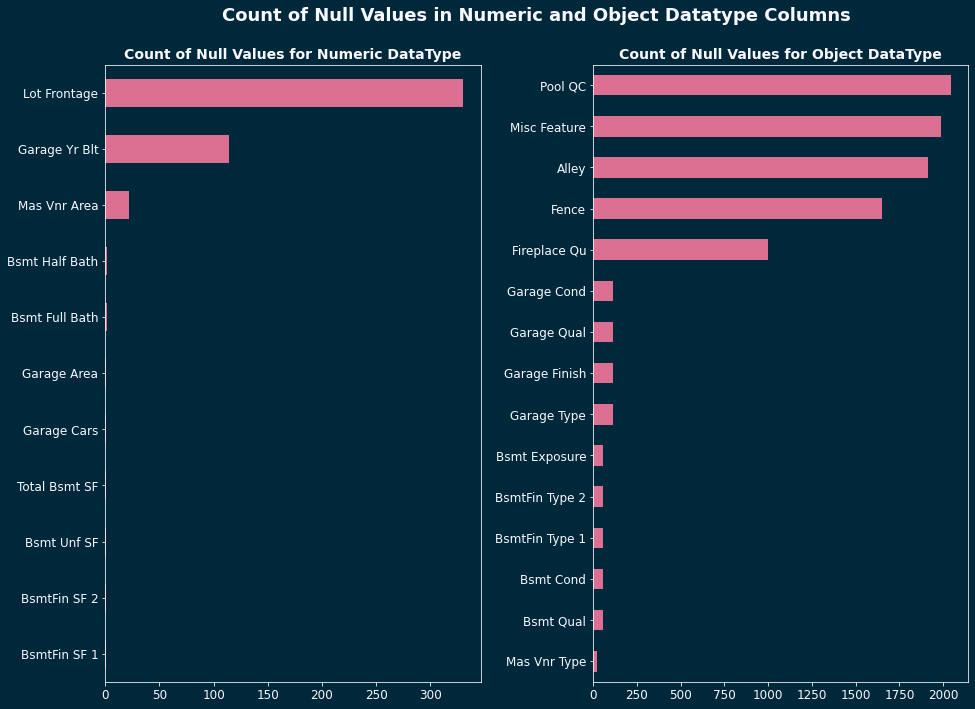

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,10), constrained_layout=True)
df_null_numeric.plot.barh(ax=ax1, facecolor='palevioletred')
ax1.set_title('Count of Null Values for Numeric DataType')
df_null_object.plot.barh(ax=ax2, facecolor='palevioletred' )
ax2.set_title('Count of Null Values for Object DataType')

fig.suptitle('Count of Null Values in Numeric and Object Datatype Columns')
format_fig(fig, 'NoFormatting')
plt.tight_layout()
plt.subplots_adjust(top=0.90, wspace = 0.30, right=0.9)


#### Lot Frontage is the top feature with numeric datatype and Pool QC is the top feature with object datatype with null values

### Identifying the count of unique elements and null values in the columns which are object datatype in the original dataset

In [13]:
df_dict = dict(zip([i for i in df.select_dtypes(object).columns] , [pd.DataFrame(df[i].value_counts(), columns=[i]) for i in df.select_dtypes(object).columns]))
ls_df_dict = []
for col in df.select_dtypes(object).columns:
    df_dict[col].index = df_dict[col].index.set_names(['unique_values'])
    df_dict[col]['feature'] = df_dict[col].columns[-1]
    df_dict[col].rename(columns = {col : 'value_counts'}, inplace=True)
    ls_df_dict.append(df_dict[col].reset_index())
    #print(df_dict[col].reset_index())
df_dict = pd.concat(ls_df_dict, ignore_index=True)
print(df_dict)


    unique_values  value_counts    feature
0              RL          1598  MS Zoning
1              RM           316  MS Zoning
2              FV           101  MS Zoning
3         C (all)            19  MS Zoning
4              RH            14  MS Zoning
..            ...           ...        ...
248           CWD            10  Sale Type
249         ConLI             7  Sale Type
250         ConLw             5  Sale Type
251           Oth             4  Sale Type
252           Con             4  Sale Type

[253 rows x 3 columns]


In [14]:
df_null = df.select_dtypes(object).isnull().sum()
df_null.index = df_null.index.set_names(['feature'])
df_null.name = 'value_counts'
df_null = df_null.to_frame()
df_null['unique_values'] = 'Null'
df_null.reset_index(inplace=True)
df_null

,feature,value_counts,unique_values
0,MS Zoning,0,Null
1,Street,0,Null
2,Alley,1911,Null
3,Lot Shape,0,Null
4,Land Contour,0,Null
5,Utilities,0,Null
6,Lot Config,0,Null
7,Land Slope,0,Null
8,Neighborhood,0,Null
9,Condition 1,0,Null


In [15]:
df_dict = pd.concat([df_dict,df_null], ignore_index=True)

In [16]:
df_dict.sort_values(by=['feature','value_counts'], inplace=True, ascending=[True,False])

In [17]:
len(df_dict['feature'].unique())

42

findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


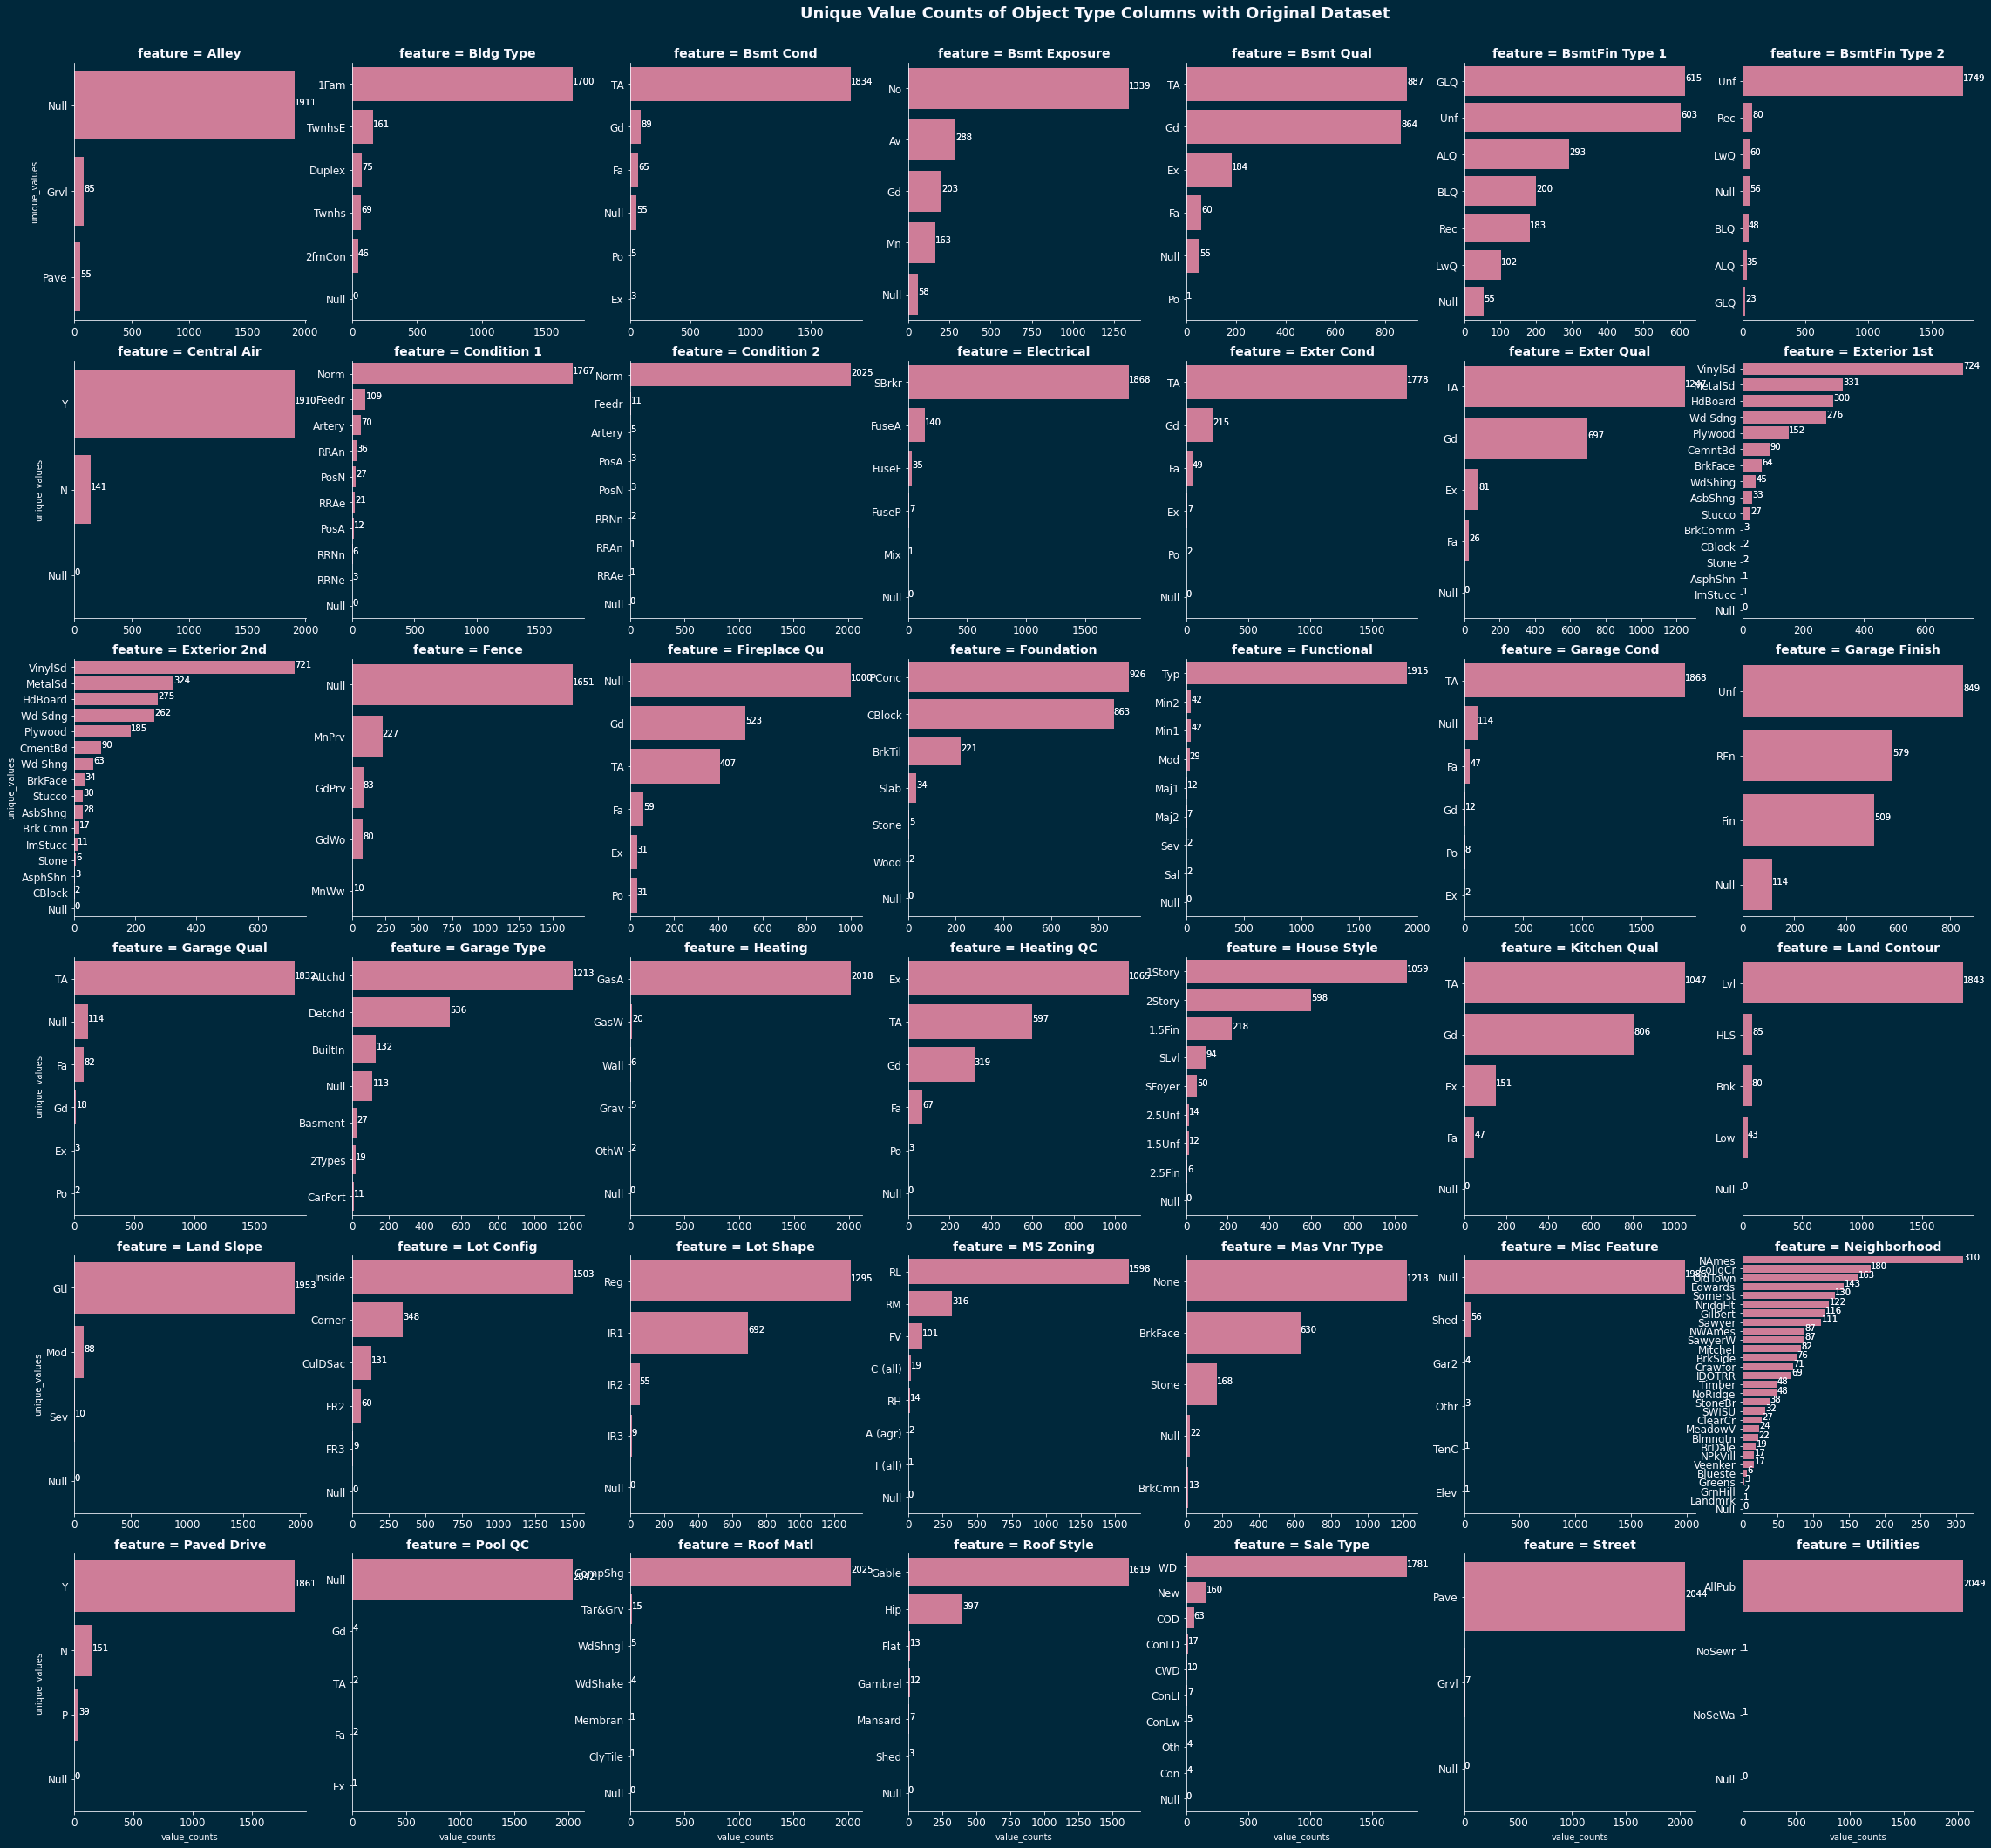

In [18]:
#function to add count value for each bar
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", color='ghostwhite') 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", color='ghostwhite')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)



g = sns.catplot(data=df_dict, x='value_counts', y='unique_values', col = 'feature', kind='bar',
                col_wrap = 7, orient = 'h', sharey=False, sharex=False, color = 'palevioletred')
g.set_titles("{col_var} = {col_name}")


show_values_on_bars(g.axes, "h", 0.5)

g.fig.suptitle('Unique Value Counts of Object Type Columns with Original Dataset')

show_values_on_bars(g.axes, "h", 0.5)
format_fig(g, 'NoFormatting', 'FacetGrid')
plt.tight_layout()
plt.subplots_adjust(top=0.95, wspace = 0.20, right=0.9)

g.savefig('../imgs/Unique_Value_Counts_of_Object_Type_Columns_with_Original_Dataset.png', dpi=dpi, facecolor=g.fig.patch.get_facecolor())

#### The idea behind generating the above unique value count plot was to inspect the number of unique categories for each individual features and their distribution. This will help in the feature selection phase to decide whether to include a given category in the model.

### Inspecting the distribution for columns with numeric datatypes

In [19]:
len_df_numeric = len(df.select_dtypes(np.number).columns)
ncols = 6
nrows = math.ceil(len_df_numeric/ncols)
len_df_numeric, nrows, ncols

(39, 7, 6)

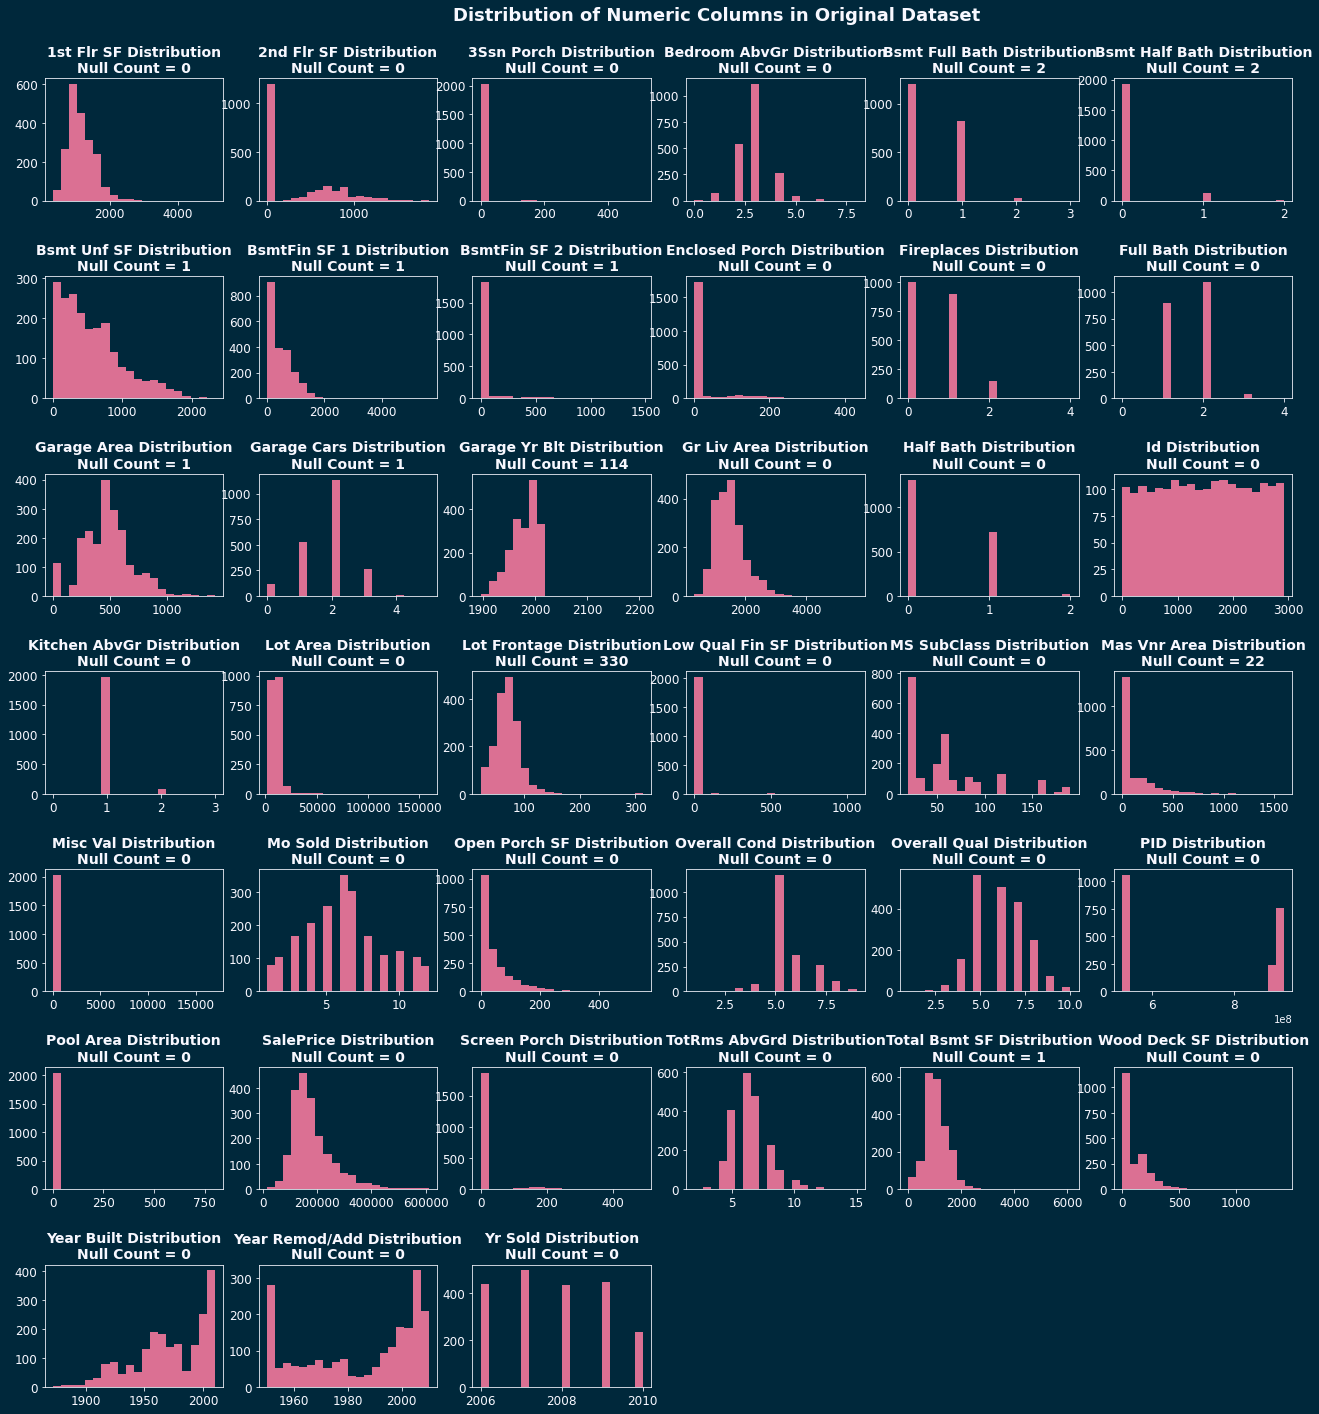

In [20]:
fig=plt.figure(figsize=(20,20))
features = df.select_dtypes(np.number).columns.sort_values()
for i, feature in enumerate(features):
    ax=fig.add_subplot(nrows,ncols,i+1)
    df[feature].hist(bins=20,ax=ax,facecolor='palevioletred')
    ax.set_title(feature+" Distribution\nNull Count = "+str(df[feature].isnull().sum()),color='red')

axs = np.array(fig.get_axes())
#show_values_on_bars(axs, "v")
fig.suptitle('Distribution of Numeric Columns in Original Dataset')
format_fig(fig, 'NoFormatting')
plt.tight_layout()
plt.subplots_adjust(top=0.93, wspace = 0.20, right=0.9)
#fig.tight_layout()
fig.savefig('../imgs/Distribution_of_Numeric_Columns_in_Original_Dataset.png', dpi=dpi, bbox_inches='tight')
plt.show()

#### The idea behind the above plot is to inspect the distribution (normal or skewed) for the numeric datatype features and also to get some idea on the spread of the data

### Inspecting dtypes of columns which may need a conversion to other type

#### Some of the features were imported as int64 format but they are essentially object dataypes

In [21]:
df['MS SubClass'].value_counts()

20     770
60     394
50     198
120    132
30     101
70      90
160     88
80      86
90      75
190     46
85      28
75      16
180     11
45      11
40       4
150      1
Name: MS SubClass, dtype: int64

In [22]:
df['Overall Qual'].value_counts()

5     563
6     506
7     431
8     250
4     159
9      77
3      29
10     23
2       9
1       4
Name: Overall Qual, dtype: int64

In [23]:
df['Overall Cond'].value_counts()

5    1168
6     368
7     270
8     101
4      70
3      35
9      29
2       6
1       4
Name: Overall Cond, dtype: int64

In [24]:
df['Sale Type'].value_counts()

WD       1781
New       160
COD        63
ConLD      17
CWD        10
ConLI       7
ConLw       5
Oth         4
Con         4
Name: Sale Type, dtype: int64

In [25]:
df[['Mas Vnr Area', 'Mas Vnr Type']].value_counts()

Mas Vnr Area  Mas Vnr Type
0.0           None            1213
120.0         BrkFace           10
180.0         BrkFace            9
176.0         BrkFace            9
16.0          BrkFace            8
                              ... 
268.0         Stone              1
67.0          Stone              1
68.0          Stone              1
262.0         BrkFace            1
1600.0        BrkFace            1
Length: 469, dtype: int64

In [26]:
df[['Mas Vnr Type']].value_counts()

Mas Vnr Type
None            1218
BrkFace          630
Stone            168
BrkCmn            13
dtype: int64

### Analyzing Null values for Possible Fix

#### The following section investigates each feature column which has null values. Possible solution to address the null values is discussed here. The actual fix for each of these columns is done later in the notebook

#### Pool Feature Columns

In [27]:
df[df['Pool Area']==0]['Pool Area'].value_counts()

0    2042
Name: Pool Area, dtype: int64

In [28]:
df[df['Pool Area']==0]['Pool QC'].isnull().sum()

2042

1. There are 2042 rows with pool area = 0. this is also the number of null values in pool quality column. This can be set to NA=No Pool

#### Misc Feature Columns

In [29]:
df[df['Misc Val']==0]['Misc Val'].value_counts()

0    1986
Name: Misc Val, dtype: int64

In [30]:
df[df['Misc Val']==0]['Misc Feature'].isnull().sum()

1986

1. There are 1986 rows with misc val=0. this is also the number of null values in misc feature column. This can be set to NA=None

#### Basement Feature Columns

In [31]:
bsmt_cols = ['Bsmt Qual', 
'Bsmt Cond', 
'Bsmt Exposure', 
'BsmtFin Type 1',
'BsmtFin Type 2', 
'BsmtFin SF 1',  
'BsmtFin SF 2', 
'Bsmt Unf SF', 
'Total Bsmt SF',
'Bsmt Full Bath',
 'Bsmt Half Bath']
df[df[bsmt_cols].isnull().any(axis='columns')][bsmt_cols].sort_values(by='Total Bsmt SF')

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
12,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1089,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1098,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1125,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1157,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1211,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1222,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1252,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1256,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1270,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
len(df[df[bsmt_cols].isnull().any(axis='columns')][bsmt_cols].sort_values(by='Total Bsmt SF'))

59

#order of rows described here is as shown above. From top to bottom we have:-
1. There are 59 rows total where either one of the basement related categories have null values
2. 54 of those have 0 area and basement features are NaN. This can be set to NA=no basement
3. 3 rows have only Bsmt exposure column with NaN values. This can be set to No which is otherwise the largest category. Safe to assume basement does not have a exposure
4. 1 row where BsmtFin Type 2 is NaN. But there is definitely a basement present. We will assume this value is GLQ which is equal to BsmtFin Type 1
5. Last row has all NaN values and can be set to NA= no basement for object columns and 0 for numeric columns
6. There are 2 rows for Bsmt Full and Half Bath with null values. this can be set to 0

#### Garage Feature Columns

In [33]:
garage_cols = ['Garage Type', 
'Garage Yr Blt', 
'Garage Finish', 
'Garage Cars', 
'Garage Area', 
'Garage Qual', 
'Garage Cond']
pd.set_option("display.max_rows", 115)
df[df[garage_cols].isnull().any(axis='columns')][garage_cols].sort_values(by='Garage Area')

,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
28,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1429,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1428,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1419,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1385,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1384,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1376,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1374,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1372,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1366,NaN,NaN,NaN,0.0,0.0,NaN,NaN


In [34]:
len(df[df[garage_cols].isnull().any(axis='columns')][garage_cols].sort_values(by='Garage Area'))

114

In [35]:
df.loc[df['Garage Yr Blt'].isnull(), ['Year Built', 'Garage Yr Blt']]

,Year Built,Garage Yr Blt
28,1895,NaN
53,1970,NaN
65,2007,NaN
79,1925,NaN
101,1920,NaN
103,1900,NaN
114,1947,NaN
120,1940,NaN
134,1925,NaN
136,1875,NaN


#order of rows described here is as shown above. From top to bottom we have:-
1. There are 114 rows with either one of the garage features with NaN values
2. 113 of those have all columns NaN except Garage cars and Garage Area which are zero. Object columns can be changed to NA=No Garage. 
3. Garage Yr Blt is the only numeric column with NaN values. However we have the info of when the house was built. We can assume garage was built along with the house. Setting Garage yr Blt NaN values to Year Built
4. Last row also has all columns NaN except Garage Type which seems to be an error. It should be changed to NA=No Garage

#### Fireplace Feature Columns

In [36]:
df[df['Fireplaces']==0]['Fireplaces'].value_counts()

0    1000
Name: Fireplaces, dtype: int64

In [37]:
df[df['Fireplaces']==0]['Fireplace Qu'].isnull().sum()

1000

1. There are 1000 rows with fireplaces=0. this is also the number of null values in fireplaces qu column. This can be set to NA=None

#### Fence
Fence has 1651 null values and there is no other related column which can be used to infer the null values. For null values set them to NA=No fence

#### Alley

Fence has 1911 null values and there is no other related column which can be used to infer the null values. For null values set them to NA=No Alley

#### Mas Vnr Type and Mas Vnr Area

In [38]:
masn_cols = ['Exterior 1st', 
'Exterior 2nd', 
'Mas Vnr Type', 
'Mas Vnr Area']
df[df[masn_cols].isnull().any(axis='columns')][masn_cols].sort_values(by='Mas Vnr Area')

,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area
22,CemntBd,CmentBd,NaN,NaN
41,VinylSd,VinylSd,NaN,NaN
86,VinylSd,VinylSd,NaN,NaN
212,VinylSd,VinylSd,NaN,NaN
276,VinylSd,VinylSd,NaN,NaN
338,WdShing,Wd Shng,NaN,NaN
431,VinylSd,VinylSd,NaN,NaN
451,VinylSd,VinylSd,NaN,NaN
591,VinylSd,VinylSd,NaN,NaN
844,VinylSd,VinylSd,NaN,NaN


In [39]:
#Checking the area of Mas Vnr Type = None
df[(df['Mas Vnr Type'] == 'None') & (df['Mas Vnr Area'] >= 0)]['Mas Vnr Area'].sort_values()

2         0.0
1378      0.0
1377      0.0
1376      0.0
1374      0.0
        ...  
1684      1.0
1148      1.0
765       1.0
810     288.0
1832    344.0
Name: Mas Vnr Area, Length: 1218, dtype: float64

In [40]:
#Checking how many area values are greater than 0 of Mas Vnr Type = None
df[(df['Mas Vnr Type'] == 'None') & (df['Mas Vnr Area'] > 0)]['Mas Vnr Area'].sort_values()

765       1.0
1148      1.0
1684      1.0
810     288.0
1832    344.0
Name: Mas Vnr Area, dtype: float64

1. So almost all of the Mas Vnr Type = None have zero area
2. So the null values of Mas Vnr Type and Mas Vnr Area can be set to None and 0 respectively
3. Possibly need to fix the above 5 values for which area is greater than zero and Mas Vnr Type is None

#### Lot Frontage
Don't include in the model for now

### Datatype conversion columns

#### For sure
1. MS SubClass
2. Overall Qual
3. Overall Cond

#### Maybe
1. Bsmt Full Bath
2. Bsmt Half Bath
3. Full Bath
4. Half Bath
5. Bedroom AbvGr
6. Kitchen AbvGr
7. TotRms AbvGrd
8. Fireplaces
9. Garage Cars


## Reading the CSV again to clean the data

In [41]:
dict_dtype = {'MS SubClass' : str, 
                'Overall Qual' : str,
               'Overall Cond' : str,
               'Bsmt Full Bath' : str,
                'Bsmt Half Bath' : str,
                'Full Bath' : str,
                'Half Bath' : str,
                'Bedroom AbvGr' : str,
                'Kitchen AbvGr' : str,
                'TotRms AbvGrd' : str,
                'Fireplaces' : str,
                'Garage Cars' : str}

In [42]:
#start the model with both For Sure and Maybe columns as string types
df = pd.read_csv('../datasets/train.csv', dtype=dict_dtype)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   object 
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            140 non-null    object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

### Null Values Manipulation

#### Functions to Fix Null Values 

##### Pool QC Column

In [44]:
def pool_qc(df):
    #There are 2042 rows with pool area = 0. this is also the number of null values in pool quality column. This can be set to NA=No Pool
    df['Pool QC'].fillna('NA', inplace=True)
    df.loc[df['Pool Area']==0,'Pool QC'].isnull().sum()
    print(f"The number of null values in the Pool Column = {df['Pool QC'].isnull().sum()}")
    return df

##### Misc Feature Column

In [45]:
def misc_feature(df):
    #There are 1986 rows with misc val=0. this is also the number of null values in misc feature column. This can be set to NA=None
    df['Misc Feature'].fillna('NA', inplace=True)
    df.loc[df['Misc Val']==0, 'Misc Feature'].isnull().sum()
    
    print(f"The number of null values in the Misc Feature Column = {df['Misc Feature'].isnull().sum()}")

    return df

##### Basement Related Features Columns

In [46]:
def basement(df):
    #1. There are 59 rows total where either one of the basement related categories have null values
    #2. 54 of those have 0 area and basement features are NaN. This can be set to NA=no basement
    #3. 3 rows have only Bsmt exposure column with NaN values. This can be set to No which is otherwise the largest category. Safe to assume basement does not have a exposure
    #4. 1 row where BsmtFin Type 2 is NaN. But there is definitely a basement present. We will assume this value is GLQ which is equal to BsmtFin Type 1
    #5. Last row has all NaN values and can be set to NA= no basement for object columns and 0 for numeric columns
    #6. There are 2 rows for Bsmt Full and Half Bath with null values. this can be set to 0

    bsmt_cols = ['Bsmt Qual', 
    'Bsmt Cond', 
    'Bsmt Exposure', 
    'BsmtFin Type 1',
    'BsmtFin Type 2', 
    'BsmtFin SF 1',  
    'BsmtFin SF 2', 
    'Bsmt Unf SF', 
    'Total Bsmt SF',
    'Bsmt Full Bath',
     'Bsmt Half Bath']
    df[df[bsmt_cols].isnull().any(axis='columns')][bsmt_cols].sort_values(by='Total Bsmt SF')
    
    #Step 1 Removing nulls from Bsmt Full Bath and Half Bath columns
    mask = df[['Bsmt Full Bath', 'Bsmt Half Bath']].isnull().any(axis='columns')
    df.loc[mask,['Bsmt Full Bath', 'Bsmt Half Bath']] = df.loc[mask,['Bsmt Full Bath', 'Bsmt Half Bath']].fillna(value = 0)
    
    #Step 2 Removing nulls from mask_cols where all of them are NaNs. First 54 rows
    mask_cols = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1','BsmtFin Type 2']
    mask = df[mask_cols].isnull().all(axis='columns')
    df.loc[mask, mask_cols] = df.loc[mask, mask_cols].fillna(value='NA')
    
    # Step 3 Removing nulls from Basement Exposure columns. Setting them to No
    df['Bsmt Exposure'].fillna('No', inplace=True)

    # Step 4 Removing null from BsmtFin Type 2. Setting it to GLQ which is the value of BsmtFin Type 1
    df['BsmtFin Type 2'].fillna('GLQ', inplace=True)
    
    # Step 5 Removing nulls from BsmtFin SF 1	BsmtFin SF 2	Bsmt Unf SF	Total Bsmt SF. Setting them to Zero
    mask_cols = ['BsmtFin SF 1',  'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF']
    mask = df[mask_cols].isnull().all(axis='columns')
    df.loc[mask, mask_cols] = df.loc[mask, mask_cols].fillna(value=0)
    
    print(f"The number of null values in the {bsmt_cols} columns = {df[bsmt_cols].isnull().sum().sum()}")
    
    df[df[bsmt_cols].isnull().any(axis='columns')][bsmt_cols].sort_values(by='Total Bsmt SF')

    return df

##### Garage Related Feature Columns

In [47]:
def garage(df):
    
    #1. There are 114 rows with either one of the garage features with NaN values
    #2. 113 of those have all columns NaN except Garage cars and Garage Area which are zero. Object columns can be changed to NA=No Garage. 
    #3. Garage Yr Blt is the only numeric column with NaN values. However we have the info of when the house was built. We can assume garage was built along with the house. Setting Garage yr Blt
    #NaN values to Year Built. Most likely these houses dont have a garage but as an assumption set the year to year house was built
    #4. Last row also has all columns NaN except Garage Type which seems to be an error. It should be changed to NA=No Garage```
    garage_cols = ['Garage Type', 
    'Garage Yr Blt', 
    'Garage Finish', 
    'Garage Cars', 
    'Garage Area', 
    'Garage Qual', 
    'Garage Cond']
    #pd.set_option("display.max_rows", 115)
    df[df[garage_cols].isnull().any(axis='columns')][garage_cols].sort_values(by='Garage Area')
    # Step 1. Garage Yr Blt Null values set to house year built
    df.loc[df['Garage Yr Blt'].isnull(), 'Garage Yr Blt'] = df.loc[df['Garage Yr Blt'].isnull(), 'Year Built']
    
    #Step 2
    mask_cols = ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']
    mask = df[mask_cols].isnull().all(axis='columns')
    df.loc[mask, mask_cols] = df.loc[mask, mask_cols].fillna(value='NA')
    
    # Step 3 Last row also has all columns NaN except Garage Type which seems to be an error. It should be changed to NA=No Garage
    # It seems that all houses 
    mask_cols = ['Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']
    mask = df[mask_cols].isnull().all(axis='columns')
    df.loc[mask, mask_cols] = df.loc[mask, mask_cols].fillna(value={'Garage Finish' : 'NA', 'Garage Cars' : 0, 'Garage Area' : 0, 'Garage Qual' : 'NA', 'Garage Cond' : 'NA'})
    
    # Additional step: Row Index 1712 has 0 cars and 0 area assigned in the above step so it should not have a garage. 
    # However the original dataset had it as detached garage. Replacing that entry with NA=No Garage
    
    #This is the code which adds one additional entry to the test dataframe as its logic is based on row index of
    #train dataset. Modifying it to not be based on row index
    
    ############################Original Code####################################################
    #df.loc[1712, 'Garage Type'] = 'NA'
    ##############################################################################################
    
    ############################New Code Added to fix test data###################################
    # Check whether this works on train data. this condition is not satisfied in test data
    mask_cols = ['Garage Type']
    mask  = (df['Garage Area'] == 0) & (df['Garage Cars'] == 0) & (df['Garage Type'] != 'NA')
    df.loc[mask, mask_cols] = 'NA'
    ##############################################################################################
    
    # Step 4 - Applicable only to test data- Fixing Row 764
    mask_cols = ['Garage Finish', 'Garage Qual', 'Garage Cond']
    mask = (df['Garage Yr Blt'] == 1910.0) & (df['Garage Area'] == 360) & (df['Garage Cars'] == "1") & (df['Garage Type'] == "Detchd")
    df.loc[mask, mask_cols] = ['Unf', 'TA', 'TA']
    
    df[df[garage_cols].isnull().any(axis='columns')][garage_cols].sort_values(by='Garage Area')
    
    print(f"The number of null values in the {garage_cols} columns = {df[garage_cols].isnull().sum().sum()}")
   
    return df    

##### Fireplace

In [48]:
def fireplace(df):
    #There are 1000 rows with fireplaces=0. this is also the number of null values in fireplaces qu column. This can be set to NA=None
    df['Fireplace Qu'].fillna('NA', inplace=True)
    print(f"The number of null values in the FirePlace Qu columns = {df['Fireplace Qu'].isnull().sum()}")
    
    return df

##### Fence

In [49]:
def fence(df):
    #Fence has 1651 null values and there is no other related column which can be used to infer the null values. For null values set them to NA=No fence
    df['Fence'].fillna('NA', inplace=True)
    print(f"The number of null values in the Fence columns = {df['Fence'].isnull().sum()}")
    
    return df

##### Alley

In [50]:
def alley(df):
    #Fence has 1911 null values and there is no other related column which can be used to infer the null values. For null values set them to NA=No Alley
    df['Alley'].fillna('NA', inplace=True)
    print(f"The number of null values in the Alley columns = {df['Alley'].isnull().sum()}")
    
    return df

##### Mas Vnr Type and Area

In [51]:
def masonry(df):
    #So the null values of Mas Vnr Type and Mas Vnr Area can be set to None and 0 respectively
    df['Mas Vnr Type'].fillna('NA', inplace=True)
    df['Mas Vnr Area'].fillna(0, inplace=True)
    print(f"The number of null values in the Masonry columns = {df[['Mas Vnr Type', 'Mas Vnr Area']].isnull().sum().sum()}")
    
    return df

##### Electrical column

In [52]:
# Only an issue in test data
# House qual is 5, overall cond is 5, garage is recently built. so electrical is set to SBrkr
def electrical(df, flag='Test'):
    if flag == 'Test':
        dftest['Electrical'].fillna(value='SBrkr', inplace=True)
    print(f"The number of null values in the Electrical columns = {df['Electrical'].isnull().sum()}")

    return df

#### Calling the functions to clean the dataset

In [53]:
# Removing null values from train dataset - Except Lot Frontage
df = pool_qc(df)
df = misc_feature(df)
df = basement(df)
df = garage(df)
df = fireplace(df)
df = fence(df)
df = alley(df)
df = masonry(df)
df = electrical(df, 'Train')

The number of null values in the Pool Column = 0
The number of null values in the Misc Feature Column = 0
The number of null values in the ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath'] columns = 0
The number of null values in the ['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond'] columns = 0
The number of null values in the FirePlace Qu columns = 0
The number of null values in the Fence columns = 0
The number of null values in the Alley columns = 0
The number of null values in the Masonry columns = 0
The number of null values in the Electrical columns = 0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   object 
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            2051 non-null   object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [55]:
df.isnull().sum().sort_values(ascending=False)

Lot Frontage       330
Id                   0
Half Bath            0
Garage Type          0
Fireplace Qu         0
Fireplaces           0
Functional           0
TotRms AbvGrd        0
Kitchen Qual         0
Kitchen AbvGr        0
Bedroom AbvGr        0
Full Bath            0
Garage Finish        0
Bsmt Half Bath       0
Bsmt Full Bath       0
Gr Liv Area          0
Low Qual Fin SF      0
2nd Flr SF           0
1st Flr SF           0
Electrical           0
Garage Yr Blt        0
Garage Cars          0
Heating QC           0
Pool Area            0
Sale Type            0
Yr Sold              0
Mo Sold              0
Misc Val             0
Misc Feature         0
Fence                0
Pool QC              0
Screen Porch         0
Garage Area          0
3Ssn Porch           0
Enclosed Porch       0
Open Porch SF        0
Wood Deck SF         0
Paved Drive          0
Garage Cond          0
Garage Qual          0
Central Air          0
Heating              0
PID                  0
Lot Config 

#### Only Lot Frontage is left with null values.

### Identifying the count of unique elements and null values in the columns which are object datatype in the CLEAN dataset

In [56]:
df_dict = dict(zip([i for i in df.select_dtypes(object).columns] , [pd.DataFrame(df[i].value_counts(), columns=[i]) for i in df.select_dtypes(object).columns]))
ls_df_dict = []
for col in df.select_dtypes(object).columns:
    df_dict[col].index = df_dict[col].index.set_names(['unique_values'])
    df_dict[col]['feature'] = df_dict[col].columns[-1]
    df_dict[col].rename(columns = {col : 'value_counts'}, inplace=True)
    ls_df_dict.append(df_dict[col].reset_index())
    #print(df_dict[col].reset_index())
df_dict = pd.concat(ls_df_dict, ignore_index=True)
print(df_dict)

    unique_values  value_counts      feature
0              20           770  MS SubClass
1              60           394  MS SubClass
2              50           198  MS SubClass
3             120           132  MS SubClass
4              30           101  MS SubClass
..            ...           ...          ...
353           CWD            10    Sale Type
354         ConLI             7    Sale Type
355         ConLw             5    Sale Type
356           Oth             4    Sale Type
357           Con             4    Sale Type

[358 rows x 3 columns]


In [57]:
df_null = df.select_dtypes(object).isnull().sum()
df_null.index = df_null.index.set_names(['feature'])
df_null.name = 'value_counts'
df_null = df_null.to_frame()
df_null['unique_values'] = 'Null'
df_null.reset_index(inplace=True)
df_null

,feature,value_counts,unique_values
0,MS SubClass,0,Null
1,MS Zoning,0,Null
2,Street,0,Null
3,Alley,0,Null
4,Lot Shape,0,Null
5,Land Contour,0,Null
6,Utilities,0,Null
7,Lot Config,0,Null
8,Land Slope,0,Null
9,Neighborhood,0,Null


In [58]:
df_dict = pd.concat([df_dict,df_null], ignore_index=True)

In [59]:
df_dict.sort_values(by=['feature','value_counts'], inplace=True, ascending=[True,False])

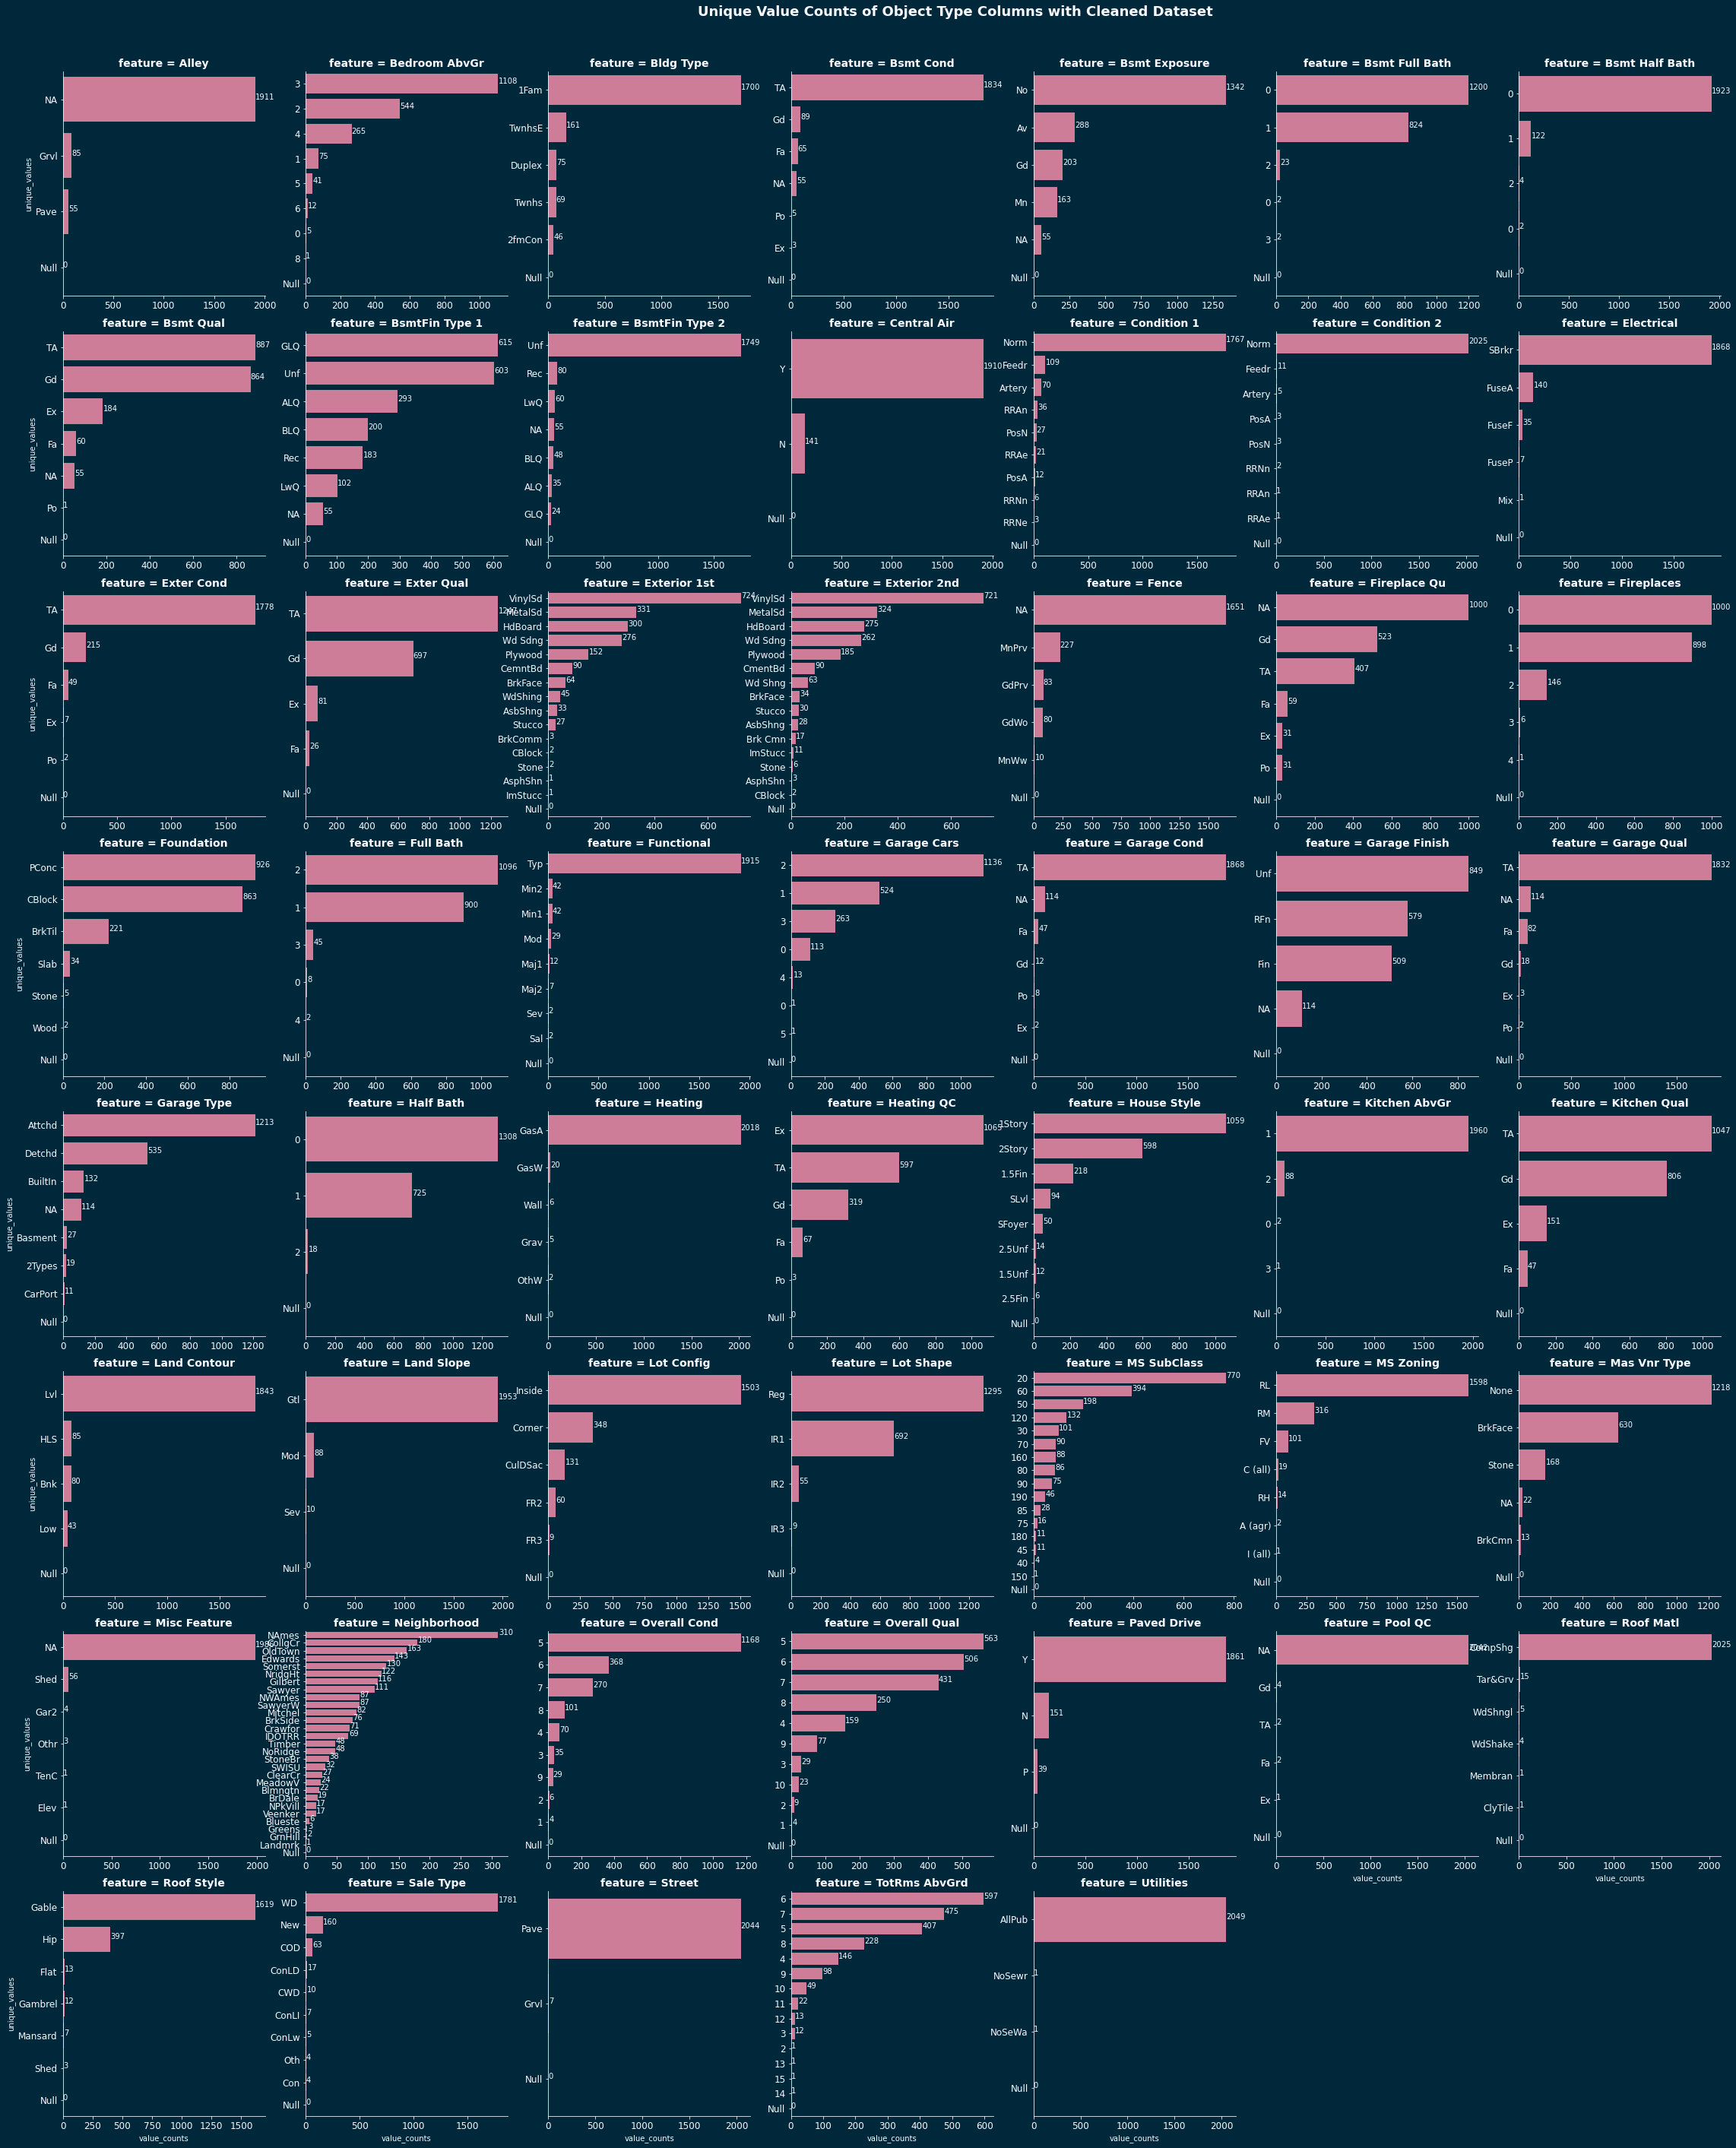

In [60]:
#function to add count value for each bar
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center", color='ghostwhite')
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() / 2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", color='ghostwhite')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)



g = sns.catplot(data=df_dict, x='value_counts', y='unique_values', col = 'feature', kind='bar',
                col_wrap = 7, orient = 'h', sharey=False, sharex=False, color = 'palevioletred')
g.set_titles("{col_var} = {col_name}")
g.fig.suptitle('Unique Value Counts of Object Type Columns with Cleaned Dataset')

show_values_on_bars(g.axes, "h", 0.5)
format_fig(g, 'NoFormatting', 'FacetGrid')
plt.tight_layout()
plt.subplots_adjust(top=0.95, wspace = 0.20, right=0.9)

g.savefig('../imgs/Unique_Value_Counts_of_Object_Type_Columns_with_Cleaned_Dataset.png', dpi=dpi, facecolor=g.fig.patch.get_facecolor())

#### This plot is similar to the one generated for the original dataset. One additional "category" of Null counts is added for each feature as spot check to check the impact of imputing the null values

### Inspecting the distribution for columns with numeric datatypes in the CLEAN dataset

In [61]:
len_df_numeric = len(df.select_dtypes(np.number).columns)
ncols = 6
nrows = math.ceil(len_df_numeric/ncols)
len_df_numeric, nrows, ncols

(27, 5, 6)

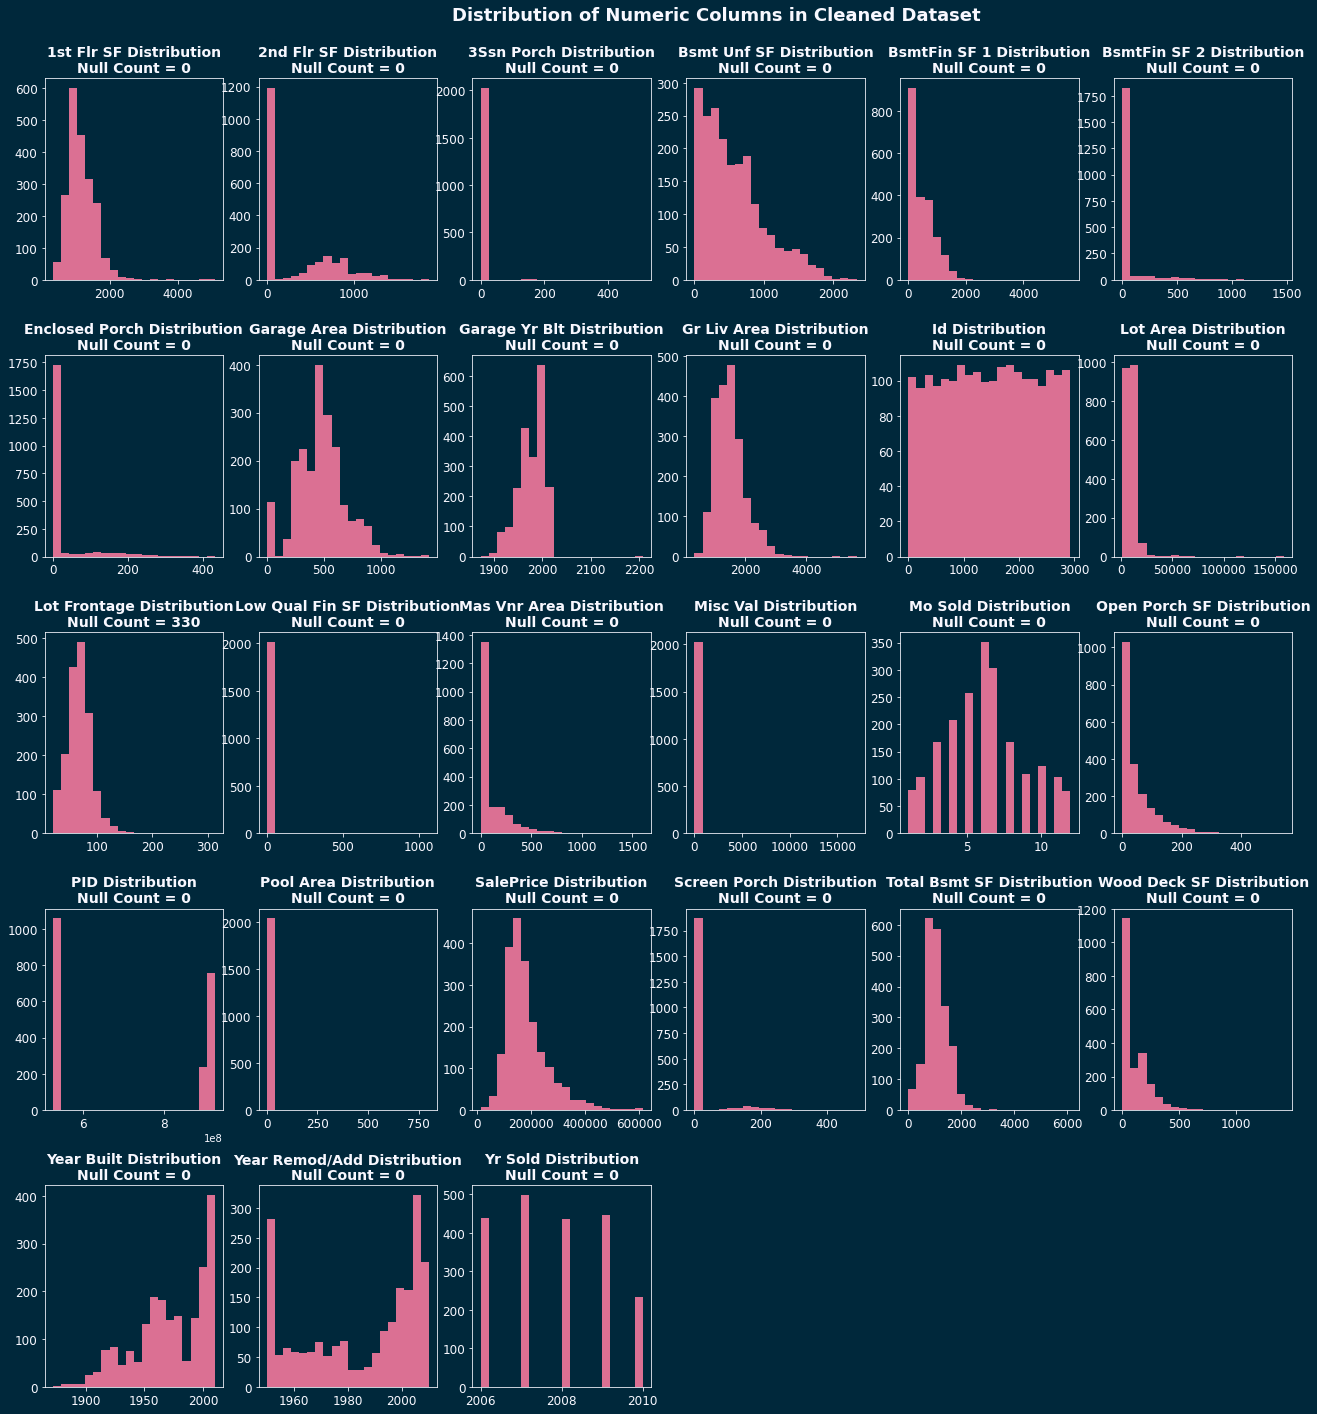

In [62]:
fig=plt.figure(figsize=(20,20))
features = df.select_dtypes(np.number).columns.sort_values()
for i, feature in enumerate(features):
    ax=fig.add_subplot(nrows,ncols,i+1)
    df[feature].hist(bins=20,ax=ax,facecolor='palevioletred')
    ax.set_title(feature+" Distribution\nNull Count = "+str(df[feature].isnull().sum()),color='red')

#axs = np.array(fig.get_axes())
#show_values_on_bars(axs, "v")
#fig.tight_layout()
fig.suptitle('Distribution of Numeric Columns in Cleaned Dataset')
format_fig(fig, 'NoFormatting')
plt.tight_layout()
plt.subplots_adjust(top=0.93, wspace = 0.20, right=0.9)

fig.savefig('../imgs/Distribution_of_Numeric_Columns_in_Cleaned_Dataset.png', dpi=dpi, bbox_inches='tight')
plt.show()

#### Null counts in the clean dataset are reported in the plot title as a spot check to check the impact of imputing the null values

### Exporting the cleaned train dataset to csv

In [63]:
df.to_csv('../datasets/train_clean_v1.csv')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2051 non-null   int64  
 1   PID              2051 non-null   int64  
 2   MS SubClass      2051 non-null   object 
 3   MS Zoning        2051 non-null   object 
 4   Lot Frontage     1721 non-null   float64
 5   Lot Area         2051 non-null   int64  
 6   Street           2051 non-null   object 
 7   Alley            2051 non-null   object 
 8   Lot Shape        2051 non-null   object 
 9   Land Contour     2051 non-null   object 
 10  Utilities        2051 non-null   object 
 11  Lot Config       2051 non-null   object 
 12  Land Slope       2051 non-null   object 
 13  Neighborhood     2051 non-null   object 
 14  Condition 1      2051 non-null   object 
 15  Condition 2      2051 non-null   object 
 16  Bldg Type        2051 non-null   object 
 17  House Style   

In [65]:
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,...,0,0,NA,NA,NA,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,...,0,0,NA,NA,NA,0,3,2010,WD,138500


### Fixing Null Values in the Test Dataset

In [66]:
dftest = pd.read_csv('../datasets/test.csv', dtype=dict_dtype)

In [67]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    object 
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            58 non-null     object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [68]:
# Removing null values from dftest - Except Lot Frontage
dftest = pool_qc(dftest)
dftest = misc_feature(dftest)
dftest = basement(dftest)
dftest = garage(dftest)
dftest = fireplace(dftest)
dftest = fence(dftest)
dftest = alley(dftest)
dftest = masonry(dftest)
dftest = electrical(dftest)


The number of null values in the Pool Column = 0
The number of null values in the Misc Feature Column = 0
The number of null values in the ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath'] columns = 0
The number of null values in the ['Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond'] columns = 0
The number of null values in the FirePlace Qu columns = 0
The number of null values in the Fence columns = 0
The number of null values in the Alley columns = 0
The number of null values in the Masonry columns = 0
The number of null values in the Electrical columns = 0


### Exporting the cleaned test dataset to csv

In [69]:
dftest.to_csv('../datasets/test_clean_v1.csv')

In [70]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 80 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               878 non-null    int64  
 1   PID              878 non-null    int64  
 2   MS SubClass      878 non-null    object 
 3   MS Zoning        878 non-null    object 
 4   Lot Frontage     718 non-null    float64
 5   Lot Area         878 non-null    int64  
 6   Street           878 non-null    object 
 7   Alley            878 non-null    object 
 8   Lot Shape        878 non-null    object 
 9   Land Contour     878 non-null    object 
 10  Utilities        878 non-null    object 
 11  Lot Config       878 non-null    object 
 12  Land Slope       878 non-null    object 
 13  Neighborhood     878 non-null    object 
 14  Condition 1      878 non-null    object 
 15  Condition 2      878 non-null    object 
 16  Bldg Type        878 non-null    object 
 17  House Style     

In [71]:
dftest

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NA,NA,NA,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NA,IR1,Lvl,...,0,0,0,NA,NA,NA,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NA,IR1,Lvl,...,0,185,0,NA,NA,NA,0,7,2009,WD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,11,2007,WD
874,1234,535126140,60,RL,90.0,14670,Pave,NA,Reg,Lvl,...,0,0,0,NA,MnPrv,NA,0,8,2008,WD
875,1373,904100040,20,RL,55.0,8250,Pave,NA,Reg,Lvl,...,0,0,0,NA,NA,NA,0,8,2008,WD
876,1672,527425140,20,RL,60.0,9000,Pave,NA,Reg,Lvl,...,0,0,0,NA,GdWo,NA,0,5,2007,WD


In [72]:
dftest.isnull().sum()

Id                   0
PID                  0
MS SubClass          0
MS Zoning            0
Lot Frontage       160
Lot Area             0
Street               0
Alley                0
Lot Shape            0
Land Contour         0
Utilities            0
Lot Config           0
Land Slope           0
Neighborhood         0
Condition 1          0
Condition 2          0
Bldg Type            0
House Style          0
Overall Qual         0
Overall Cond         0
Year Built           0
Year Remod/Add       0
Roof Style           0
Roof Matl            0
Exterior 1st         0
Exterior 2nd         0
Mas Vnr Type         0
Mas Vnr Area         0
Exter Qual           0
Exter Cond           0
Foundation           0
Bsmt Qual            0
Bsmt Cond            0
Bsmt Exposure        0
BsmtFin Type 1       0
BsmtFin SF 1         0
BsmtFin Type 2       0
BsmtFin SF 2         0
Bsmt Unf SF          0
Total Bsmt SF        0
Heating              0
Heating QC           0
Central Air          0
Electrical 

### Quality Check Between Train and Test Data

#### Train and test datasets are compared to each other for 2 purposes
1. To check for data ranges for numeric data columns
2. To check for unique categories within each features between the 2 datasets

In [73]:
min_train = df.select_dtypes(np.number).min()
max_train = df.select_dtypes(np.number).max()

min_test = dftest.select_dtypes(np.number).min()
max_test = dftest.select_dtypes(np.number).max()

min_train.name = "Train Dataset Minimum"
max_train.name = "Train Dataset Maximum"

min_test.name = "Test Dataset Minimum"
max_test.name = "Test Dataset Maximum"

pd.set_option('display.float_format', lambda x: '%.0f' % x)
df_train_test_min_max = pd.concat([min_train, min_test, max_train, max_test], axis=1)
df_train_test_min_max

,Train Dataset Minimum,Test Dataset Minimum,Train Dataset Maximum,Test Dataset Maximum
Id,1,2,2930,2928
PID,526301100,526302110,924152030,1007100110
Lot Frontage,21,21,313,182
Lot Area,1300,1477,159000,215245
Year Built,1872,1880,2010,2010
Year Remod/Add,1950,1950,2010,2010
Mas Vnr Area,0,0,1600,1378
BsmtFin SF 1,0,0,5644,2288
BsmtFin SF 2,0,0,1474,1526
Bsmt Unf SF,0,0,2336,2046


In [74]:
pd.reset_option('display.float_format')

In [75]:
#comparing the column names
df.columns.difference(dftest.columns)

Index(['SalePrice'], dtype='object')

In [76]:
df_train_unique = pd.Series({c: df[c].unique() for c in df.select_dtypes(object)})
df_train_unique.name = 'Train Unique Values'

In [77]:
df_test_unique = pd.Series({c: dftest[c].unique() for c in dftest.select_dtypes(object)})
df_test_unique.name = 'Test Unique Values'

In [78]:
df_train_test_unique = pd.concat([df_train_unique, df_test_unique], axis=1)
df_train_test_unique

,Train Unique Values,Test Unique Values
MS SubClass,"[60, 20, 50, 180, 160, 70, 120, 190, 85, 30, 9...","[190, 90, 60, 30, 20, 160, 120, 70, 80, 50, 85..."
MS Zoning,"[RL, RM, FV, C (all), A (agr), RH, I (all)]","[RM, RL, FV, RH, C (all), I (all)]"
Street,"[Pave, Grvl]","[Pave, Grvl]"
Alley,"[NA, Pave, Grvl]","[Grvl, NA, Pave]"
Lot Shape,"[IR1, Reg, IR2, IR3]","[Reg, IR1, IR3, IR2]"
Land Contour,"[Lvl, HLS, Bnk, Low]","[Lvl, Bnk, Low, HLS]"
Utilities,"[AllPub, NoSeWa, NoSewr]","[AllPub, NoSewr]"
Lot Config,"[CulDSac, Inside, Corner, FR2, FR3]","[Inside, CulDSac, Corner, FR2, FR3]"
Land Slope,"[Gtl, Sev, Mod]","[Gtl, Mod, Sev]"
Neighborhood,"[Sawyer, SawyerW, NAmes, Timber, Edwards, OldT...","[OldTown, Sawyer, Gilbert, NAmes, MeadowV, Col..."


In [79]:
def symmetric_difference(x):
    return list(set(x['Train Unique Values']).symmetric_difference(x['Test Unique Values']))
def train_difference_test(x):
    return list(set(x['Train Unique Values'])-set(x['Test Unique Values']))
def test_difference_train(x):
    return list(set(x['Test Unique Values'])-set(x['Train Unique Values']))

In [80]:
df_train_test_unique['Symmetric Difference'] = df_train_test_unique[['Train Unique Values', 'Test Unique Values']].apply(symmetric_difference, axis=1)
df_train_test_unique['train_not_test'] = df_train_test_unique[['Train Unique Values', 'Test Unique Values']].apply(train_difference_test, axis=1)
df_train_test_unique['test_not_train'] = df_train_test_unique[['Train Unique Values', 'Test Unique Values']].apply(test_difference_train, axis=1)


In [81]:
df_train_test_unique

,Train Unique Values,Test Unique Values,Symmetric Difference,train_not_test,test_not_train
MS SubClass,"[60, 20, 50, 180, 160, 70, 120, 190, 85, 30, 9...","[190, 90, 60, 30, 20, 160, 120, 70, 80, 50, 85...",[150],[150],[]
MS Zoning,"[RL, RM, FV, C (all), A (agr), RH, I (all)]","[RM, RL, FV, RH, C (all), I (all)]",[A (agr)],[A (agr)],[]
Street,"[Pave, Grvl]","[Pave, Grvl]",[],[],[]
Alley,"[NA, Pave, Grvl]","[Grvl, NA, Pave]",[],[],[]
Lot Shape,"[IR1, Reg, IR2, IR3]","[Reg, IR1, IR3, IR2]",[],[],[]
Land Contour,"[Lvl, HLS, Bnk, Low]","[Lvl, Bnk, Low, HLS]",[],[],[]
Utilities,"[AllPub, NoSeWa, NoSewr]","[AllPub, NoSewr]",[NoSeWa],[NoSeWa],[]
Lot Config,"[CulDSac, Inside, Corner, FR2, FR3]","[Inside, CulDSac, Corner, FR2, FR3]",[],[],[]
Land Slope,"[Gtl, Sev, Mod]","[Gtl, Mod, Sev]",[],[],[]
Neighborhood,"[Sawyer, SawyerW, NAmes, Timber, Edwards, OldT...","[OldTown, Sawyer, Gilbert, NAmes, MeadowV, Col...","[Landmrk, GrnHill]","[Landmrk, GrnHill]",[]


In [82]:
df_train_test_unique.loc['Mas Vnr Type','Train Unique Values']

array(['BrkFace', 'None', 'NA', 'Stone', 'BrkCmn'], dtype=object)

In [83]:
#sorting the symmetric difference column by the length of list
df_train_test_unique['len'] = df_train_test_unique['Symmetric Difference'].str.len()
df_train_test_unique = df_train_test_unique.sort_values(by='len', ascending=False).drop(columns='len')
df_train_test_unique

,Train Unique Values,Test Unique Values,Symmetric Difference,train_not_test,test_not_train
Condition 2,"[Norm, RRNn, Feedr, Artery, PosA, PosN, RRAe, ...","[Norm, Feedr, PosA]","[RRNn, PosN, RRAe, Artery, RRAn]","[RRNn, PosN, RRAe, Artery, RRAn]",[]
TotRms AbvGrd,"[6, 8, 5, 7, 9, 4, 12, 11, 10, 3, 14, 2, 13, 15]","[9, 10, 7, 5, 6, 3, 8, 4, 11, 12]","[14, 15, 2, 13]","[13, 14, 15, 2]",[]
Exterior 1st,"[HdBoard, VinylSd, Wd Sdng, BrkFace, Plywood, ...","[AsbShng, Plywood, VinylSd, Wd Sdng, CemntBd, ...","[PreCast, Stone, CBlock, ImStucc]","[CBlock, Stone, ImStucc]",[PreCast]
Roof Matl,"[CompShg, WdShngl, Tar&Grv, WdShake, Membran, ...","[CompShg, Metal, WdShake, Tar&Grv, WdShngl, Roll]","[ClyTile, Metal, Membran, Roll]","[ClyTile, Membran]","[Metal, Roll]"
Heating,"[GasA, GasW, Grav, Wall, OthW]","[GasA, GasW, Grav, Floor]","[Floor, Wall, OthW]","[OthW, Wall]",[Floor]
Exterior 2nd,"[Plywood, VinylSd, Wd Sdng, HdBoard, MetalSd, ...","[AsbShng, Plywood, VinylSd, Wd Sdng, CmentBd, ...","[PreCast, Stone, Other]",[Stone],"[PreCast, Other]"
Misc Feature,"[NA, Shed, TenC, Gar2, Othr, Elev]","[NA, Shed, Othr, Gar2]","[Elev, TenC]","[Elev, TenC]",[]
Pool QC,"[NA, Fa, Gd, Ex, TA]","[NA, Ex, TA]","[Gd, Fa]","[Gd, Fa]",[]
Garage Cars,"[2, 1, 3, 0, 4, 5, 0]","[1, 2, 4, 0, 3]","[0, 5]","[0, 5]",[]
Functional,"[Typ, Mod, Min2, Maj1, Min1, Sev, Sal, Maj2]","[Typ, Min2, Min1, Mod, Maj1, Maj2]","[Sal, Sev]","[Sev, Sal]",[]


#### The above dataframe lists all the features of object datatype by comparing the unique labels in train and test dataset. Differences are calculated for each feature to see which category is missing in either of the datasets. This will help during creating the dummies phase of the modeling workflow and also during feature selection. If a particular label is missing in for eg test dataframe, it would not be advisable to include them in the train dataset

In [84]:
#https://stackoverflow.com/questions/37880032/concatenation-of-pandas-dataframes-including-rows-source-dataframe-category
keys = ['train', 'test']
dfs_ls = [df, dftest]
df_train_test_merge = pd.concat([dft.assign(datatype=key) for key, dft in zip(keys, dfs_ls)])

In [85]:
df_train_test_merge

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,datatype
0,109,533352170,60,RL,NaN,13517,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,3,2010,WD,130500.0,train
1,544,531379050,60,RL,43.0,11492,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,4,2009,WD,220000.0,train
2,153,535304180,20,RL,68.0,7922,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,1,2010,WD,109000.0,train
3,318,916386060,60,RL,73.0,9802,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,174000.0,train
4,255,906425045,50,RL,82.0,14235,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,3,2010,WD,138500.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,1662,527377110,60,RL,80.0,8000,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,11,2007,WD,NaN,test
874,1234,535126140,60,RL,90.0,14670,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,8,2008,WD,NaN,test
875,1373,904100040,20,RL,55.0,8250,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,8,2008,WD,NaN,test
876,1672,527425140,20,RL,60.0,9000,Pave,NA,Reg,Lvl,...,0,NA,GdWo,NA,0,5,2007,WD,NaN,test


In [86]:
df_train_test_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2929 entries, 0 to 877
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Id               2929 non-null   int64  
 1   PID              2929 non-null   int64  
 2   MS SubClass      2929 non-null   object 
 3   MS Zoning        2929 non-null   object 
 4   Lot Frontage     2439 non-null   float64
 5   Lot Area         2929 non-null   int64  
 6   Street           2929 non-null   object 
 7   Alley            2929 non-null   object 
 8   Lot Shape        2929 non-null   object 
 9   Land Contour     2929 non-null   object 
 10  Utilities        2929 non-null   object 
 11  Lot Config       2929 non-null   object 
 12  Land Slope       2929 non-null   object 
 13  Neighborhood     2929 non-null   object 
 14  Condition 1      2929 non-null   object 
 15  Condition 2      2929 non-null   object 
 16  Bldg Type        2929 non-null   object 
 17  House Style    

### Inspecting the distribution for columns with numeric datatypes between Train and Test Dataset in the CLEAN dataset

In [87]:
len_df_numeric = len(df_train_test_merge.select_dtypes(np.number).columns)
ncols = 5
nrows = math.ceil(len_df_numeric/ncols)
len_df_numeric, nrows, ncols

(27, 6, 5)

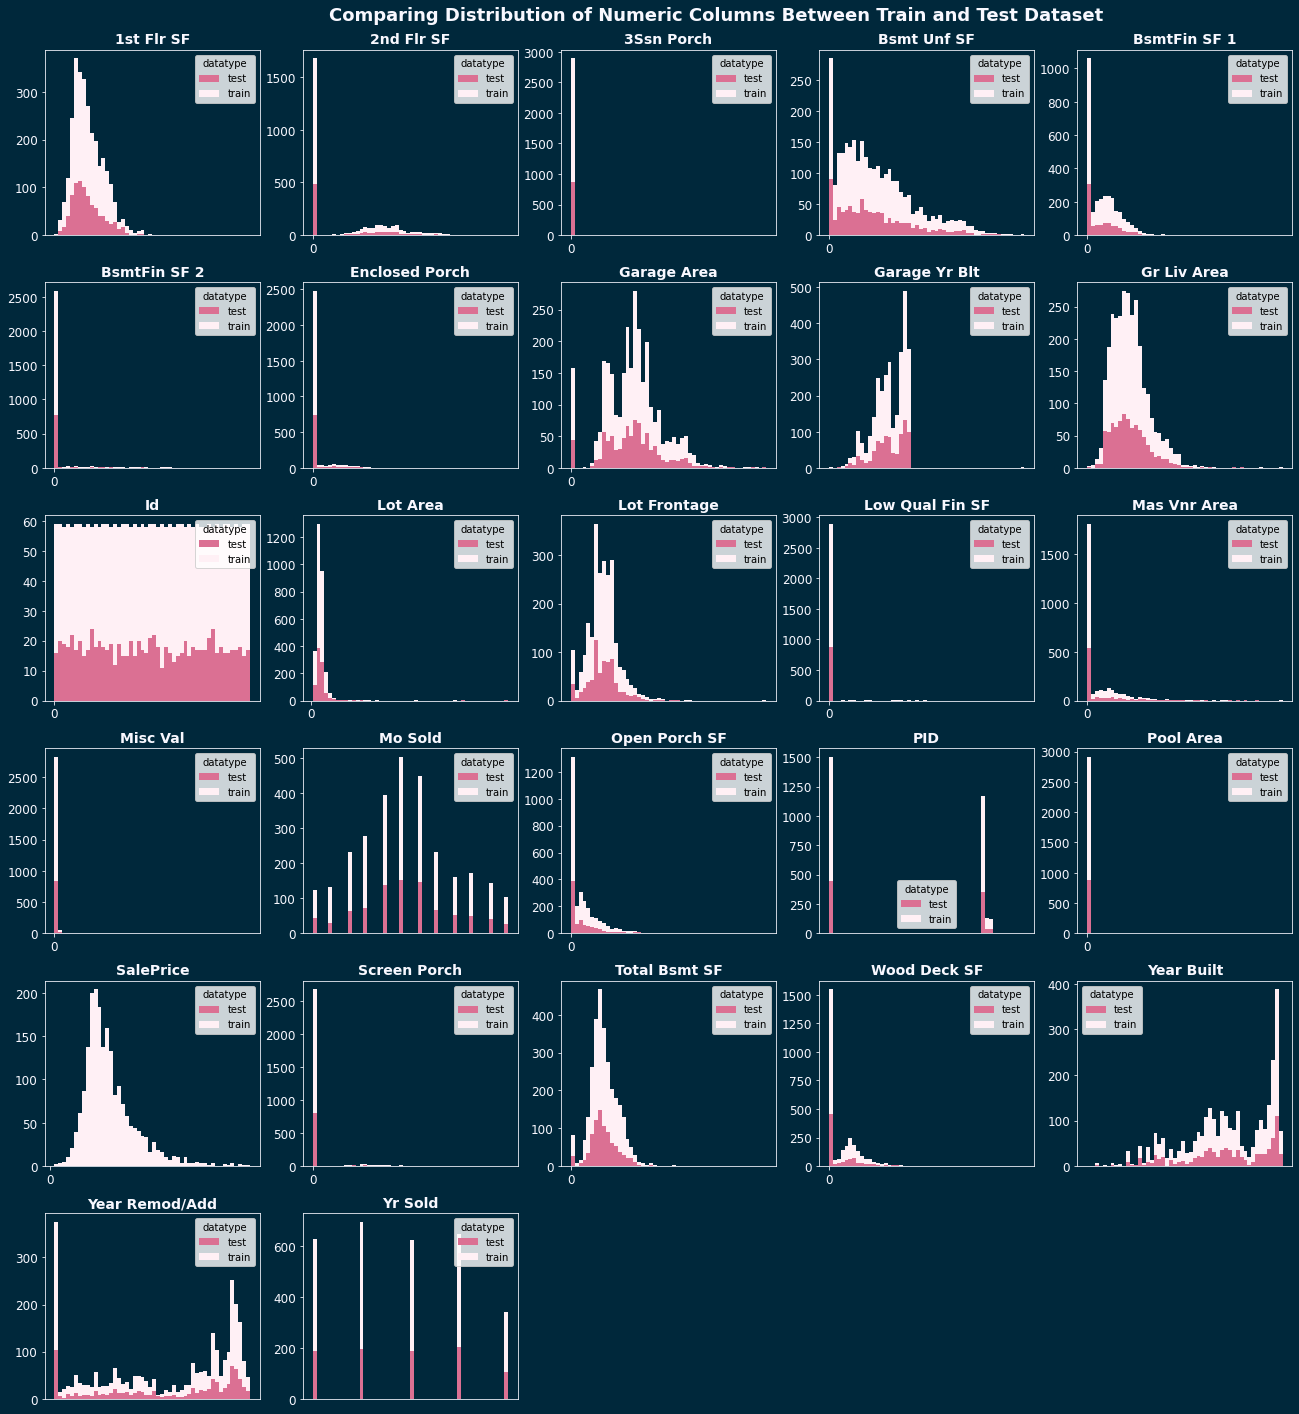

In [88]:
fig=plt.figure(figsize=(20,20))
features = df.select_dtypes(np.number).columns.sort_values()
for i, feature in enumerate(features):
    ax=fig.add_subplot(nrows,ncols,i+1)
    sns.barplot()
    df_train_test_merge.pivot(values=feature, columns='datatype' ).plot.hist(bins=50, stacked=True, 
                                                            ax=ax, color=['palevioletred', 'lavenderblush'])
    #df[feature].hist(bins=20,ax=ax,facecolor='palevioletred')
    ax.set_title(feature,color='red')
    ax.yaxis.get_label().set_visible(False)
fig.suptitle('Comparing Distribution of Numeric Columns Between Train and Test Dataset')
format_fig(fig, 'NoFormatting')

plt.tight_layout()
plt.subplots_adjust(top=0.95, wspace = 0.20, right=0.9)

#fig.tight_layout()
fig.savefig('../imgs/Comparing_Distribution_of_Numeric_Columns_Between_Train_and_Test_Dataset.png', dpi=dpi, bbox_inches='tight')
plt.show()

#### The above plot is a visual representation to compare the distribution between train and test datasets

In [89]:
df_train_test_merge['PID'][:10]

0    533352170
1    531379050
2    535304180
3    916386060
4    906425045
5    535126040
6    908186070
7    535154050
8    535353130
9    535426130
Name: PID, dtype: int64

#### 3 properties are identified which are potentially duplicates. 2 of them are in the train dataset  and 1 of them is in the test dataset. These properties share the exact same features with different PIDs. The following dataframe lists these 3 properties with consecutive rows being duplicates

In [90]:
dupli_cols = ['MS SubClass', 'MS Zoning', 'Gr Liv Area', 'Lot Area', 'Year Built', 'Yr Sold', 'Mo Sold','Sale Type', 'SalePrice']
df_train_test_merge[df_train_test_merge.duplicated(subset=dupli_cols, keep=False)].sort_values(by=['Lot Area', 'SalePrice'])

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice,datatype
69,1483,907425015,120,RM,NaN,4426,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,5,2008,WD,NaN,test
295,1482,907425010,120,RM,NaN,4426,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,5,2008,WD,NaN,test
93,811,906226100,90,RL,64.0,7018,Pave,NA,Reg,Bnk,...,0,NA,GdPrv,NA,0,6,2009,WD,118858.0,train
499,812,906226110,90,RL,64.0,7018,Pave,NA,Reg,Bnk,...,0,NA,NA,NA,0,6,2009,WD,118858.0,train
791,763,904301060,90,RL,60.0,10800,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,3,2009,WD,179000.0,train
1584,764,904301070,90,RL,60.0,10800,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,3,2009,WD,179000.0,train
